forward prop in NUMPY:
================


In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [2]:
def load_coffee_data():
    """ Creates a coffee roasting data set.
        roasting duration: 12-15 minutes is best
        temperature range: 175-260C is best
    """
    rng = np.random.default_rng(2)
    X = rng.random(400).reshape(-1,2)
    X[:,1] = X[:,1] * 4 + 11.5          # 12-15 min is best
    X[:,0] = X[:,0] * (285-150) + 150  # 350-500 F (175-260 C) is best
    Y = np.zeros(len(X))
    
    i=0
    for t,d in X:
        y = -3/(260-175)*t + 21
        if (t > 175 and t < 260 and d > 12 and d < 15 and d<=y ):
            Y[i] = 1
        else:
            Y[i] = 0
        i += 1

    return (X, Y.reshape(-1,1))

In [3]:
def g(x):
    return 1 / (1 + math.exp(-x))


In [4]:
def dense(a_in,W,b):

    """
      here a_in:1d array;
              b: 1d array;
              W: w perapeter of neurons its shape(n,m) denots that their are n number of features in a_in and m number of neurons;
              
    """
    units=W.shape[1]
    a_out=np.zeros(units)
    for j in range(units):
        w=W[:,j]
        z=np.dot(w,a_in)+b[j]
        a_out[j]=g(z)
    return a_out

In [5]:
# def sequential(x):
#     a1=dense(x,W1,b1)
#     a2=dense(a1,W2,b2)
#     a3=dense(a2,W3,b3)
#     a4=dense(a3,w4,b4)
#     f_x=a4
#     return f_x

In [6]:
X,Y=load_coffee_data()
print(X.shape,Y.shape)

(200, 2) (200, 1)


Ploting THis Coffee rosting data using matplot lib
===============================

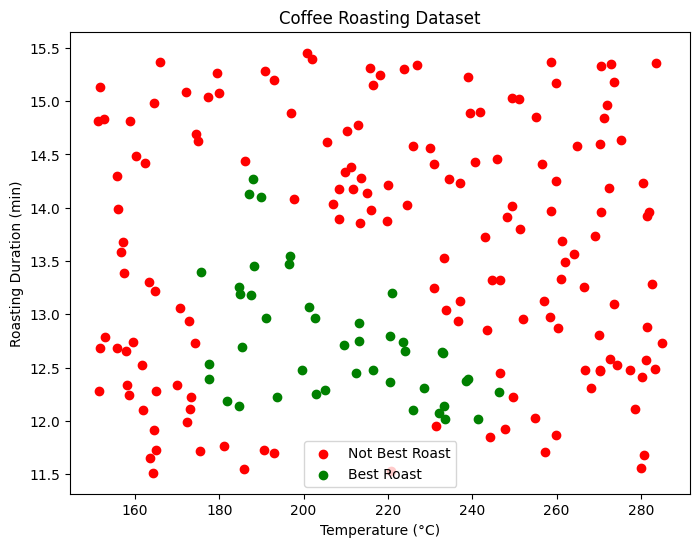

In [7]:
plt.figure(figsize=(8, 6))
plt.scatter(X[Y[:,0]==0, 0], X[Y[:,0]==0, 1], c='red', label='Not Best Roast')
plt.scatter(X[Y[:,0]==1, 0], X[Y[:,0]==1, 1], c='green', label='Best Roast')
plt.xlabel('Temperature (°C)')
plt.ylabel('Roasting Duration (min)')
plt.legend()
plt.title('Coffee Roasting Dataset')
plt.show()

In [8]:
print("Before Normalization",end="\n")
print(f"Temperature MAX,Min :{np.max(X[:,0]):0.2f},{np.min(X[:,0]):0.2f}")
print(f"Duration MAX,Min :{np.max(X[:,1]):0.2f},{np.min(X[:,1]):0.2f}")


Before Normalization
Temperature MAX,Min :284.99,151.32
Duration MAX,Min :15.45,11.51


In [9]:
norm_l=tf.keras.layers.Normalization(axis=-1)
norm_l.adapt(X) 
Xn = norm_l(X)
print(f"Temperature Max, Min post normalization: {np.max(Xn[:,0]):0.2f}, {np.min(Xn[:,0]):0.2f}")
print(f"Duration    Max, Min post normalization: {np.max(Xn[:,1]):0.2f}, {np.min(Xn[:,1]):0.2f}")

Temperature Max, Min post normalization: 1.66, -1.69
Duration    Max, Min post normalization: 1.79, -1.70


In [10]:
Xt = np.tile(Xn,(1000,1))
Yt= np.tile(Y,(1000,1))   
print(Xt.shape, Yt.shape)   

(200000, 2) (200000, 1)


In [11]:
tf.random.set_seed(1234)  # applied to achieve consistent results
model = Sequential(
    [
        tf.keras.Input(shape=(2,)),
        Dense(3, activation='sigmoid', name = 'layer1'),
        Dense(1, activation='sigmoid', name = 'layer2')
     ]
)

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ layer1 (Dense)                  │ (None, 3)              │             9 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer2 (Dense)                  │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13 (52.00 B)

 Trainable params: 13 (52.00 B)

 Non-trainable params: 0 (0.00 B)

The weights  𝑊
  should be of size (number of features in input, number of units in the layer) while the bias  𝑏
  size should match the number of units in the layer:

In the first layer with 3 units, we expect W to have a size of (2,3) and  𝑏
  should have 3 elements.
In the second layer with 1 unit, we expect W to have a size of (3,1) and  𝑏
  should have 1 element.

In [13]:
W1, b1 = model.get_layer("layer1").get_weights()
W2, b2 = model.get_layer("layer2").get_weights()
print(f"W1{W1.shape}:\n", W1, f"\nb1{b1.shape}:", b1)
print(f"W2{W2.shape}:\n", W2, f"\nb2{b2.shape}:", b2)

W1(2, 3):
 [[-0.33080202  0.20736134  0.28156304]
 [ 1.0312371   0.62627006  0.3393296 ]] 
b1(3,): [0. 0. 0.]
W2(3, 1):
 [[1.1934716 ]
 [0.61280787]
 [0.25747383]] 
b2(1,): [0.]


In [14]:
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics = ['accuracy']  # Add this
)


history = model.fit(
    Xt, Yt,            
    epochs =30
)


Epoch 1/30
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.7423 - loss: 0.4663
Epoch 2/30
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.8936 - loss: 0.2601
Epoch 3/30
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.9380 - loss: 0.1764
Epoch 4/30
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9420 - loss: 0.1541
Epoch 5/30
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9406 - loss: 0.1456
Epoch 6/30
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.9427 - loss: 0.1408
Epoch 7/30
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.9472 - loss: 0.1374
Epoch 8/30
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.9498 - loss: 0.1345
Epoch 9/30
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.9500 - loss: 0.1319
Epoch 10/30
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.9500 - loss: 0.1296
Epoch 11/30
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.9500 - loss: 0.1276
Epoch 12/30
6250/6250 ━━━━━━━━

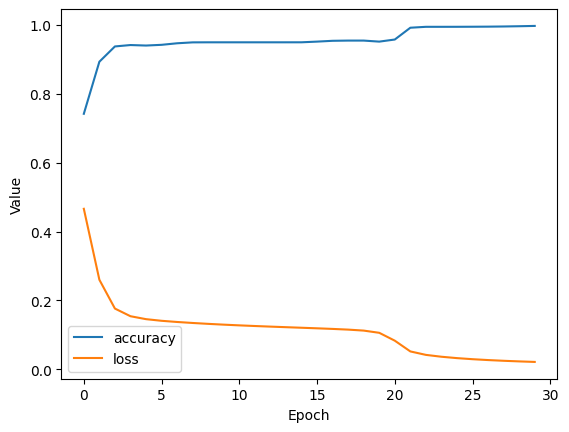

In [15]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['loss'], label='loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

In [16]:

loss, acc = model.evaluate(X, Y)
print(f"Test Accuracy: {acc:.2f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7850 - loss: 7.1781  
Test Accuracy: 0.79


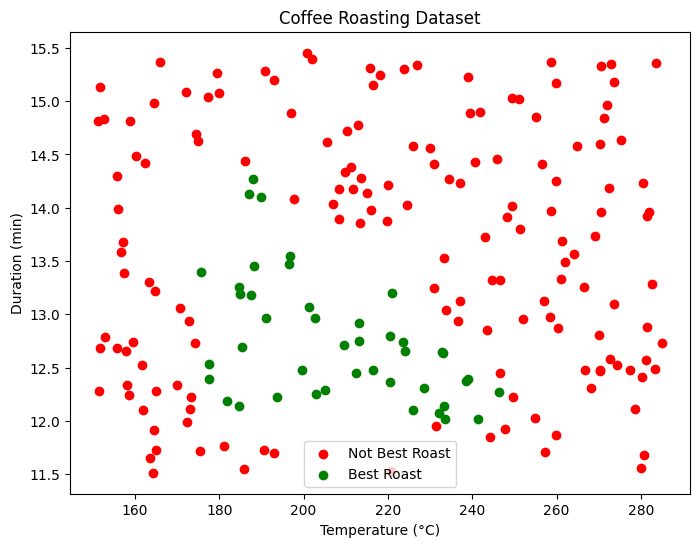

c:\Users\HP\Desktop\supervisedmachine learning\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


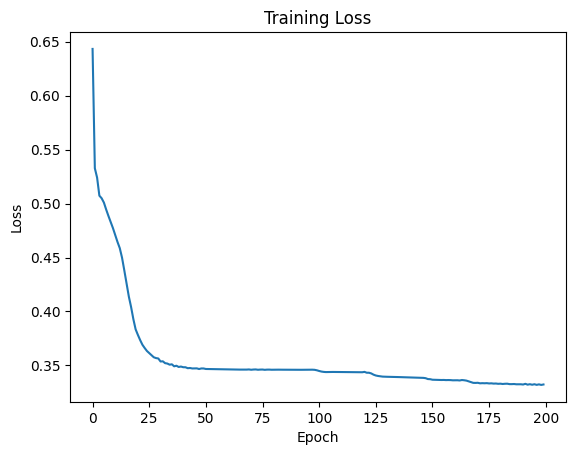

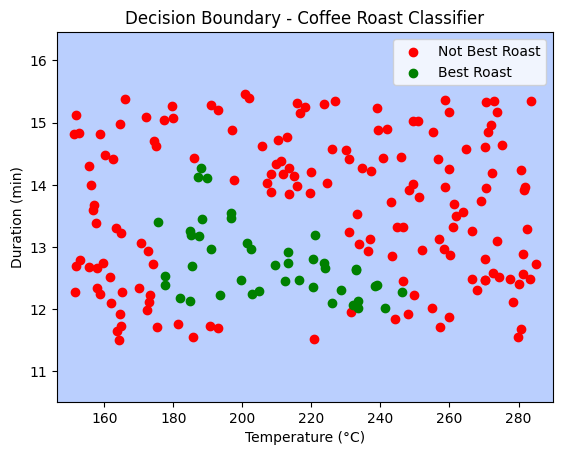

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Coffee roasting data
def load_coffee_data():
    rng = np.random.default_rng(2)
    X = rng.random(400).reshape(-1, 2)
    X[:, 1] = X[:, 1] * 4 + 11.5        # duration (12–15 min best)
    X[:, 0] = X[:, 0] * (285 - 150) + 150  # temp (175–260°C best)
    Y = np.zeros(len(X))
    
    for i, (t, d) in enumerate(X):
        y_line = -3 / (260 - 175) * t + 21
        if (175 < t < 260 and 12 < d < 15 and d <= y_line):
            Y[i] = 1
        else:
            Y[i] = 0
            
    return X, Y.reshape(-1, 1)

# Load data
X, Y = load_coffee_data()

# Plot dataset
plt.figure(figsize=(8, 6))
plt.scatter(X[Y[:,0]==0, 0], X[Y[:,0]==0, 1], c='red', label='Not Best Roast')
plt.scatter(X[Y[:,0]==1, 0], X[Y[:,0]==1, 1], c='green', label='Best Roast')
plt.xlabel('Temperature (°C)')
plt.ylabel('Duration (min)')
plt.legend()
plt.title('Coffee Roasting Dataset')
plt.show()

# Normalize features (important for NN training)
X_min = X.min(axis=0)
X_max = X.max(axis=0)
X_norm = (X - X_min) / (X_max - X_min)

# Build TensorFlow model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation='relu', input_shape=(2,)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(0.05),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train model
history = model.fit(X_norm, Y, epochs=200, verbose=0)

# Plot training loss
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# Decision boundary plot
def plot_decision_boundary(model, X, Y):
    x_min, x_max = X[:,0].min() - 5, X[:,0].max() + 5
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_norm = (grid - X_min) / (X_max - X_min)
    preds = model.predict(grid_norm, verbose=0)
    Z = preds.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, levels=[0, 0.5, 1], cmap="coolwarm", alpha=0.6)
    plt.scatter(X[Y[:,0]==0, 0], X[Y[:,0]==0, 1], c='red', label='Not Best Roast')
    plt.scatter(X[Y[:,0]==1, 0], X[Y[:,0]==1, 1], c='green', label='Best Roast')
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Duration (min)')
    plt.legend()
    plt.title('Decision Boundary - Coffee Roast Classifier')
    plt.show()

plot_decision_boundary(model, X, Y)


In [18]:
loss, acc = model.evaluate(X, Y)
print(f"Test Accuracy: {acc:.2f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7850 - loss: 1332.3219  
Test Accuracy: 0.79
